# Andrew Bui

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints
import pandas as pd



import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta,AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, Trace_ELBO, config_enumerate, infer_discrete

import random

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Data

In [2]:
df_data = pd.read_pickle(r'./data_set+1.zip')
df_data

,data
0,0.205676
1,0.575321
2,1.346189
3,-2.107491
4,0.237493
...,...
19995,2.239438
19996,0.032034
19997,-0.980857
19998,0.591560


### Use the Sklearn Gaussian Mixture and Grid Search (BIC score) to determine number of components

In [3]:
data_a = df_data.copy()
X = np.array(data_a)
X

array([[ 0.20567635],
       [ 0.57532055],
       [ 1.34618909],
       ...,
       [-0.98085746],
       [ 0.5915597 ],
       [ 0.18360177]])

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X)
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


,Number of components,Type of covariance,BIC score
13,2,diag,14595.918322
1,2,spherical,14596.005881
19,2,full,14599.502025
2,3,spherical,14624.512233
14,3,diag,14625.091082


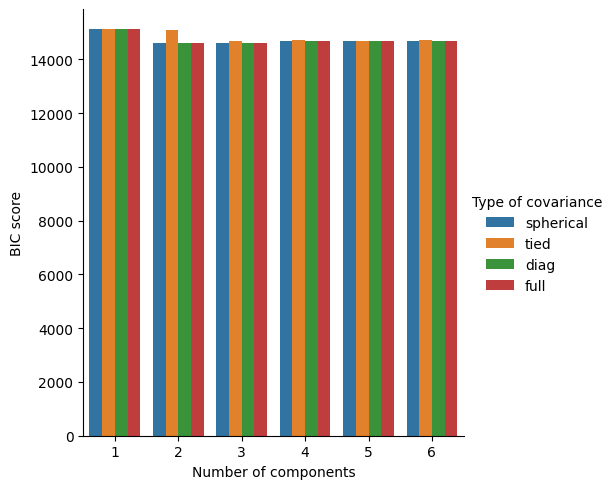

In [5]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

In [6]:
print(f"Number of components: {grid_search.best_params_['n_components']}")
print(f"Covariance Type: {grid_search.best_params_['covariance_type']}")

Number of components: 2
Covariance Type: diag


In [7]:
gm = GaussianMixture(n_components=grid_search.best_params_['n_components'], covariance_type= grid_search.best_params_['covariance_type'] ,random_state=888).fit(X)
gm.weights_, gm.means_ , gm.covariances_

(array([0.67630297, 0.32369703]),
 array([[ 0.22553854],
        [-0.37988513]]),
 array([[0.8702499 ],
        [5.82253573]]))

In [8]:
data_l = list(df_data.data)
data = torch.tensor(data_l)

In [9]:
data.shape

torch.Size([20000])

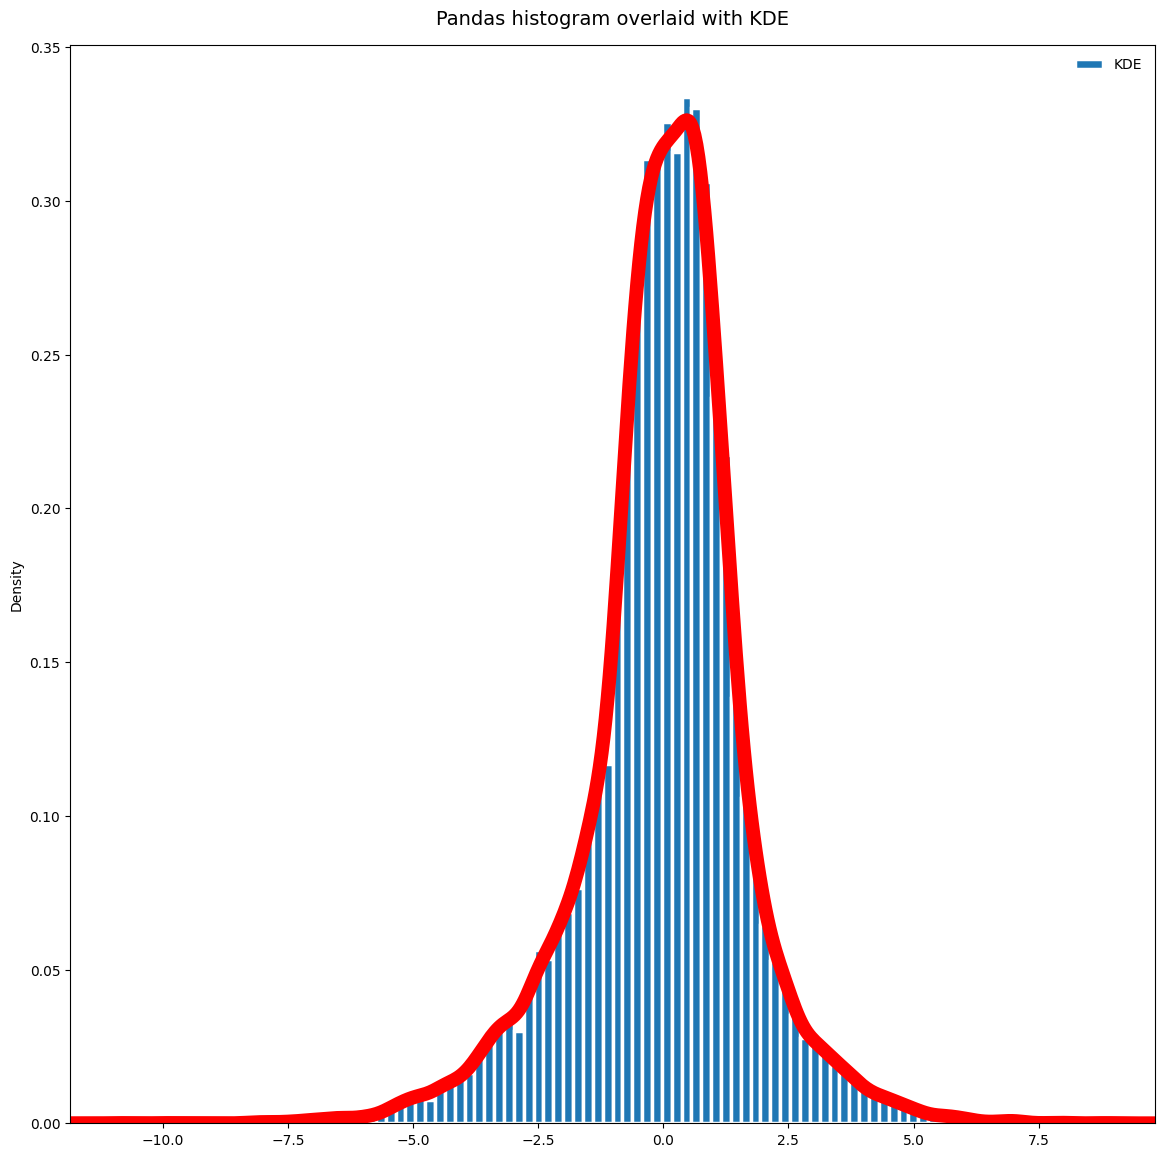

In [10]:
#this code displays the histogram of the data set with a smooth curve overlaid
import seaborn as sns

plt.rcParams["figure.figsize"] = (14,14)

ax = df_data['data'].plot.hist(bins=100, density=True, edgecolor='w', linewidth=2.5)

# Save default x-axis limits for final formatting because the pandas kde
# plot uses much wider limits which usually decreases readability
xlim = ax.get_xlim()

# Plot pandas KDE
df_data['data'].plot.density(color='r', linewidth = 10,alpha=1, ax=ax) # same as df['var'].plot.kde()
    
# Reset x-axis limits and edit legend and add title
ax.set_xlim(xlim)
ax.legend(labels=['KDE'], frameon=False)
ax.set_title('Pandas histogram overlaid with KDE', fontsize=14, pad=15)

plt.show()

In [11]:
# we first have to define the pyro model. We first specify the prior. There are three groups of parameters: the weights i.e.
# the distribution over {0,1,2}, the means for each of the tree Gaussians and their variances. These are all independent so
# the prior is a product of the distributions over each parameter
K=2

@config_enumerate
def model(data):
    samples = []
    # the distribution pi is sampled from a Dirichlet distribution. The Dirichlet is a distribution over the
    # probability simplex i.e. all vectors $x_1,x_2,...,x_n$ with x_i > 0 and summing up to 1
    # each of the parameters are stored in the pyro.param_store as items in a dict, as we can see they all have to be named.
    # In pyro distributions are basically characterized by their samples
    weights=pyro.sample('weights',dist.Dirichlet(0.5*torch.ones(K)))
    
    #the pyro.plate specifies an array of independent distributions. Here the distribution for each of the means is a
    #Gaussian with mean 0 and variance 10, the variances have a LogNormal distribution since the have to be > 0.
    # these distributions are stored in an array in the param_store named 'components'
    with pyro.plate('components',K):
        #the prior distriburion of the means
        locs = pyro.sample('locs',dist.Normal(0.,10.))
        # the prior distribution of the variances
        scales = pyro.sample('scales',dist.LogNormal(0.,2.))
        
    #here is the likelihood, for each data point an assignment to a Gaussian and then it is a sample from that Gaussian
    # first a sample from the distribution pi, which in turn is a sample from the Dirichlet distribution above.
    # then a sample from the corresponding Gaussian with mean and variance sampled from the appropriate priors
    with pyro.plate('data',len(data)):
        assignment = pyro.sample('assignment',dist.Categorical(weights))
        pyro.sample('obs',dist.Normal(locs[assignment],scales[assignment]),obs=data)
        

In [12]:
optim = pyro.optim.Adam({'lr':0.01,'betas':[0.8,0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [13]:
#Here we initialize the values, the 'weights' = [1/3,1/3,1/3], the 'scales = variances' = [1,1,1]
# and the 'locs=means' = randomly chosen from the data with equal probability
def init_loc_fn(site):
    if site['name'] == 'weights':
        return torch.ones(K)/K
    if site['name'] == 'scales':
        return torch.ones(K)
    if site['name'] == 'locs':
        return data[torch.multinomial(torch.ones(len(data))/len(data),K)]
    raise ValueError(site['name'])

In [14]:
seed = 888 #np.random.randint(1,1000)
pyro.set_rng_seed(seed) #this initializes the random number generator
pyro.clear_param_store() #This clears out any previous values that might still be stored
    
guide = AutoDelta(poutine.block(model,expose=['weights','locs','scales']),init_loc_fn =  init_loc_fn )
#Here we define the Variational Distribution as a DElta function. The initial parameters are set
#by the init_loc_fn function

svi = SVI(model,guide,optim,loss=elbo)
#This is the object that takes care of all the inference and does stochastic variational inference
#to find the optimal parameters (i.e. maximizing the ElBO)

In [15]:
#Here we run the training loop, the svi object takes care of computing the Monte Carlo gradient
#and updating the parameters at each step
losses = []
for i in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    if i % 10 == 0:
        print(loss)

44849.03515625
42141.30078125
40435.23828125
39347.3828125
38641.3984375
38192.98828125
37908.015625
37719.95703125
37586.69140625
37485.32421875
37399.7421875
37318.94140625
37231.48828125
37128.046875
37011.6328125
36903.06640625
36822.6796875
36771.2890625
36738.9140625
36715.25390625
36694.99609375
36675.86328125
36657.69140625
36639.26953125
36621.28515625
36602.94921875
36584.5546875
36565.83203125
36546.98046875
36528.109375
36509.265625
36490.62890625
36472.1015625
36454.1328125
36437.04296875
36421.16015625
36406.4609375
36393.51171875
36382.15625
36372.5234375
36364.8125
36358.67578125
36353.82421875
36350.25390625
36347.65234375
36346.0625
36344.58203125
36343.86328125
36343.31640625
36342.89453125
36342.875
36342.85546875
36342.8125
36342.71875
36342.6796875
36342.734375
36342.6796875
36342.6640625
36342.71484375
36342.73046875
36342.78125
36342.77734375
36342.76953125
36342.765625
36342.76171875
36342.76171875
36342.76171875
36342.76171875
36342.7578125
36342.7578125
36342

Text(0.5, 1.0, 'Convergence of SVI')

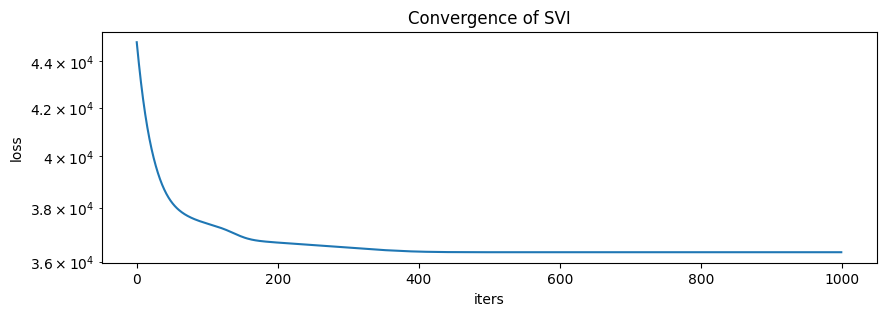

In [16]:
plt.figure(figsize=(10,3),dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI')

### Pyro Results

In [17]:
map_estimates = guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scales = map_estimates['scales']
print('weights ={}'.format(weights.data.numpy()))
print('locs={}'.format(locs.data.numpy()))
print('scales = {}'.format(scales.data.numpy()))

weights =[0.4182867  0.58171326]
locs=[-0.26310813  0.24001858]
scales = [2.2385068 0.8246434]


### SKLearn Results

In [23]:
print(f'weights = {gm.weights_}')
print(f'locs = {gm.means_}')
print(f'scales =  {gm.covariances_}')

weights = [0.67630297 0.32369703]
locs = [[ 0.22553854]
 [-0.37988513]]
scales =  [[0.8702499 ]
 [5.82253573]]


Text(0, 0.5, 'probability density')

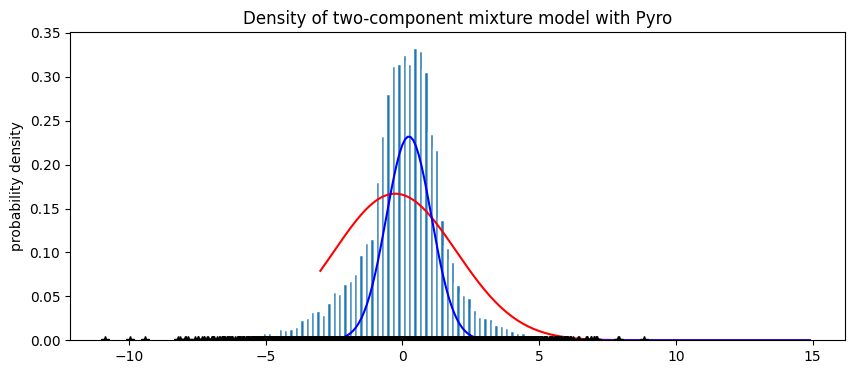

In [19]:
X = np.arange(-3, 15, 0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scales[0].item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scales[1].item())

plt.figure(figsize=(10, 4), dpi=100).set_facecolor("white")
plt.plot(X, Y1, "r-")
plt.plot(X, Y2, "b-")
df_data['data'].plot.hist(bins=100, density=True, edgecolor='w', linewidth=2.5)
#plt.plot(X, Y1 + Y2, "k--")
plt.plot(data.data.numpy(), np.zeros(len(data)), "k*")
plt.title("Density of two-component mixture model with Pyro")
plt.ylabel("probability density")

Text(0, 0.5, 'probability density')

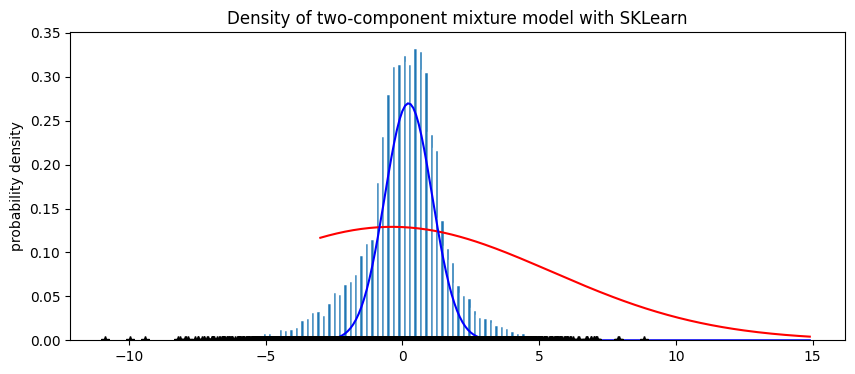

In [20]:
X = np.arange(-3, 15, 0.1)
Y1 = gm.weights_[1].item() * scipy.stats.norm.pdf((X - gm.means_ [1].item()) / gm.covariances_[1].item())
Y2 = gm.weights_[0].item() * scipy.stats.norm.pdf((X - gm.means_ [0].item()) / gm.covariances_[0].item())


plt.figure(figsize=(10, 4), dpi=100).set_facecolor("white")
plt.plot(X, Y1, "r-")
plt.plot(X, Y2, "b-")
df_data['data'].plot.hist(bins=100, density=True, edgecolor='w', linewidth=2.5)
#plt.plot(X, Y1 + Y2, "k--")
plt.plot(data.data.numpy(), np.zeros(len(data)), "k*")
plt.title("Density of two-component mixture model with SKLearn")
plt.ylabel("probability density")

With the 2 Components, my solution fits the histogram pretty well. It got the geeral shape and the distribution. The Sklearn model work better than the Pyro model. 